In [1]:
## Imports

import sys, os
from pathlib import Path

parent_folder = str(Path.cwd().parents[0])
if parent_folder not in sys.path:
    sys.path.append(parent_folder)

from sigpy import mri
from sklearn.decomposition import PCA
import sigpy as sp
import cupy as cp
import numpy as np
import twixtools
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt
from admm.utils_moco import stacked_nufft_operator,golden_angle_2d_readout, golden_angle_coords_3d, pocs, phase_based_gating_peak_to_peak, phase_based_gating, create_gates

### Load Data and Reshape

In [2]:

data_path = Path('/home/lilianae/data/NaF_MtSinai/')
output_path = parent_folder/Path('data/processed/')
print(f'output path = {output_path}')

if not os.path.exists(output_path):
    os.makedirs(output_path)

data_file = data_path /'anon_meas_MID00118_FID60738_Tho_fl3d_star_vibe_991_nav_tj_2000sp_AllCoils_SOS.dat'

multi_twix = twixtools.read_twix(str(data_file))
mapped = twixtools.map_twix(multi_twix)

output path = /home/lilianae/projects/data/processed
Software version: VD/VE (!?)

Scan  0


100%|██████████| 15.9G/15.9G [00:13<00:00, 1.31GB/s]


In [3]:
# mapped[0] is sens data

print(mapped[0])
data_0 = mapped[0]['image']
print(data_0.non_singleton_dims)
data_0.flags['remove_os']=True
print(data_0.non_singleton_dims)
print(data_0.shape)
# won't work:
#data_0 = data_0[:].squeeze()
echo_num=0                                                  # first echo is spoke data
num_points = int(mapped[0]['hdr']['Config']['NImageLins'])  # number of points on one spoke
kspace_0 = data_0[...,echo_num,0,0,0,:,0,0,:,:,:num_points]
kspace_0 = kspace_0.squeeze()
# print(kspace_0.shape)
kspace_0 = np.transpose(kspace_0,(2,0,1,3))
print(kspace_0.shape)  ## Shape = (15, 58, 2002, 256) -> (channels, partitions, lines, columns)
## 58 excitations of the same spoke -> one dimension will be 100,000 (temporal dimension)

{'image': <twixtools.map_twix.twix_array object at 0x705edc1d5c30>, 'hdr': {'Config': {'CPUCount': 12.0, 'MaxMemory': 42059.0, 'MaxRawObjectSize': 31643.0, 'MaxRawObjectSizePrioRecon': 1200.0, 'ProtectedSize': 1250.0, 'RAIDSize': 0.0, 'PDSFastSize': 0.0, 'PDSSaveSize': 0.0, 'NumberOfGPUs': 0.0, 'PatientID': '', 'PatientBirthDay': '', 'PatientSex': 2.0, 'tPatientName': 'Subject_01', 'SubProtocolIndex': '', 'PatientLOID': '53.0.449222745', 'StudyLOID': '53.0.449222753', 'SeriesLOID': '53.0.449222760', 'ProtocolChangeHistory': '', 'tStudyDescription': '', 'relSliceNumber': '0 -1 -1 -1 -1 -1 -1 -1 -1 -1  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  -1 -1 -1 -1 -1 -1 -1 -1', 'relPartitionNumber': '1 

(15, 58, 2002, 256)


### Determine Center of K-space

Text(0, 0.5, 'slices')

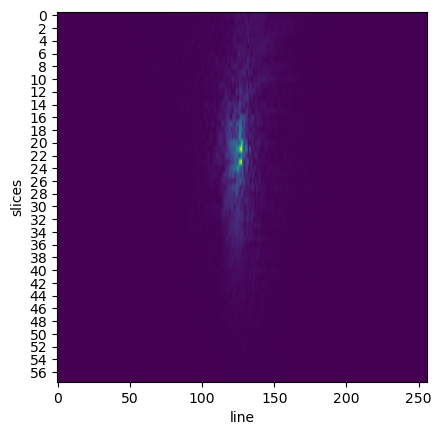

In [4]:
# show slice x line; check, where the kspace center in the through-slice 
# direction is (may not be in the exact middle due to partial Fourier etc.)
plt.imshow(np.abs(kspace_0[0,:,0,...]), aspect=kspace_0.shape[3]/kspace_0.shape[1])
gca = plt.gca()
gca.set_yticks(np.arange(0,kspace_0.shape[1],2))
gca.set_xlabel("line")
gca.set_ylabel("slices")

Text(0, 0.5, 'spokes (first 100)')

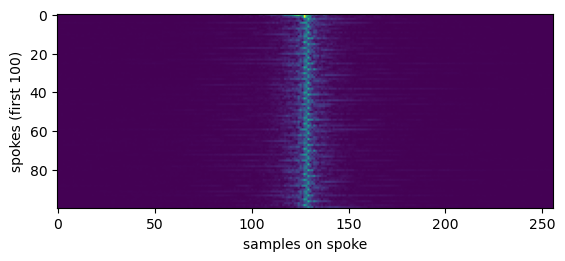

In [5]:
# quick check: show data for a couple of spokes, kspace center should be in the middle:
center_slice_index = 22 # from plot above

plt.imshow(np.abs(kspace_0[0,center_slice_index,0:100,...]))
plt.xlabel('samples on spoke')
plt.ylabel('spokes (first 100)')

### Determine coil to use for respiratory signal

Show signal for a number of coils, check visually which coil shows a good resp. signal (roughly 10-14 peaks per minute)

In [6]:

# num_slices = kspace_0.shape[1] 
# TR = float(mapped[0]['hdr']['Config']['TR'])/1000000 # us to seconds

# fs=1/TR # sample rate
# cutoff = 0.25          # in Hz -> roughly 15 resp/minute
# nyq = 0.5*fs

# one_minute_timescale = np.arange(0, 60., 2002)

# def butter_lowpass_filter(data, cutoff, fs, order):
#     normal_cutoff = cutoff / nyq
#     # Get the filter coefficients 
#     b, a = butter(order, normal_cutoff, btype='low', analog=False)
#     y = filtfilt(b, a, data)
#     return y

# coil=0 
# fig, axs = plt.subplots(4,4,figsize=(25,20))

# print(kspace_0.shape)
# for r in range(4):
#     for c in range(4):
#         # take average of two values around the center:
#         if coil==15:
#             break
#         signal = np.mean(np.abs(kspace_0[coil,center_slice_index,:len(one_minute_timescale),132:134]), axis=-1)
        
#         signal_lp_flt = butter_lowpass_filter(signal, cutoff, fs, order=2)

#         axs[r,c].plot(one_minute_timescale, signal, label='raw sig.')
#         axs[r,c].plot(one_minute_timescale, signal_lp_flt, label='filtered sig.')
#         axs[r,c].set_xlabel('seconds')
#         axs[r,c].set_title('coil ' + str(coil))
#         axs[r,c].legend()
#         coil+=1
# plt.tight_layout()


# plt.figure(2)
# coil_idx = 8
# signal = np.mean(np.abs(kspace_0[coil_idx,center_slice_index,:len(one_minute_timescale),132:134]), axis=-1)
# signal_lp_flt = butter_lowpass_filter(signal, cutoff, fs, order=2)
# plt.plot(one_minute_timescale, signal, label='raw sig.')
# plt.plot(one_minute_timescale, signal_lp_flt, label='filtered sig.')
# plt.xlabel('seconds')
# plt.title('coil ' + str(coil_idx))
# plt.legend()

### Stack Coil Data and PCA

TR from data: 0.006 sec
Sampling frequency (Hz): 166.667
full timescale goes to 696.69
coil matrix shape: (15, 116116)


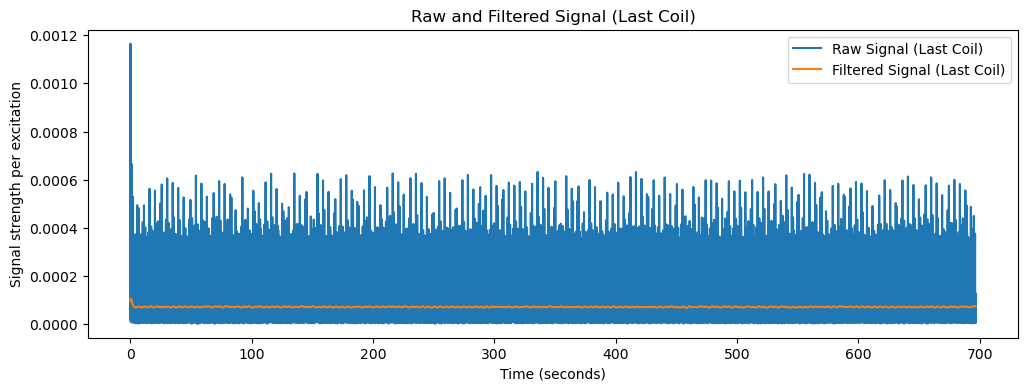

Explained variance ratio: [0.62771117]


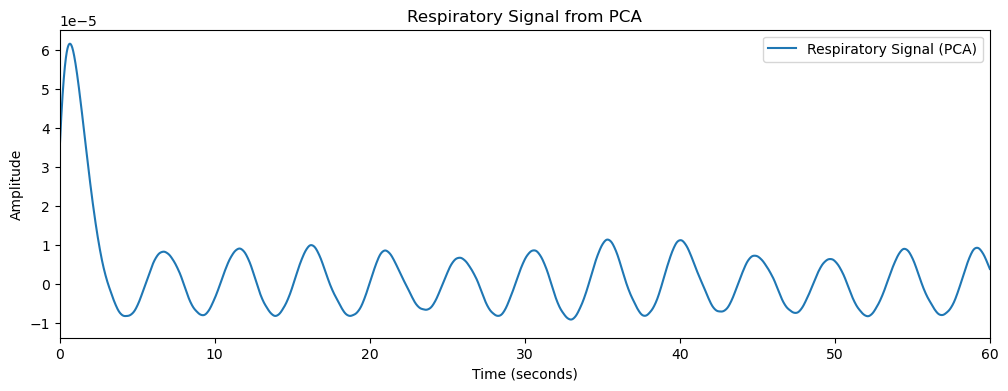

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.decomposition import PCA

def butter_lowpass_filter(data, cutoff_hz, fs_hz, order=2):
    nyq = 0.5 * fs_hz
    normal_cutoff = cutoff_hz / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def get_resp_signal(ksp_data, mapped):
    num_coils, num_slices, num_spokes, num_samples = ksp_data.shape

    TR = float(mapped[0]['hdr']['Config']['TR'])/1000000. ## microseconds to seconds
    print(f"TR from data: {TR} sec")

    n_samples = num_spokes * num_slices  # total time points/temporal samples

    # Sampling frequency in Hz
    fs = 1/(TR)
    print(f"Sampling frequency (Hz): {fs:.3f}")

    cutoff = 0.25  # respiratory frequency in Hz (~15 bpm)

    # Sanity check: cutoff must be less than Nyquist
    if cutoff >= fs / 2:
        cutoff = 0.49 * fs
        print(f"Cutoff frequency adjusted to: {cutoff:.3f} Hz to stay below Nyquist")

    # Build full time scale in SECONDS
    full_time_scale_s = np.arange(n_samples) * TR  # time in s
    print(f'full timescale goes to {full_time_scale_s[-1]}')

    signal_all_coils = []
    for c in range(num_coils):
        # mean magnitude over samples 130:140, shape (num_slices, num_spokes)
        signal = np.mean(np.abs(ksp_data[c, :, :, 130:140]), axis=-1)
        signal = signal.T.flatten()  # flatten to 1D (time points)

        filtered_signal = butter_lowpass_filter(signal, cutoff, fs, order=2)
        signal_all_coils.append(filtered_signal)

    coil_matrix = np.stack(signal_all_coils, axis=0)  # shape: (coils, time points)

    print(f"coil matrix shape: {coil_matrix.shape}")

    # plot raw and filtered signal from last coil as example (time in seconds)
    plt.figure(figsize=(12, 4))
    plt.plot(full_time_scale_s, signal, label="Raw Signal (Last Coil)")
    plt.plot(full_time_scale_s, filtered_signal, label="Filtered Signal (Last Coil)")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Signal strength per excitation")
    plt.title("Raw and Filtered Signal (Last Coil)")
    plt.legend()
    # plt.xlim(0, 60)  # show first 60 seconds
    plt.show()

    return coil_matrix, TR

def perform_pca(coil_matrix, n_components=1):
    # coil_matrix shape: (coils, time_points)
    data_for_pca = coil_matrix.T  # shape: (time_points, coils)
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(data_for_pca)

    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    return pcs, pca.explained_variance_ratio_

def plot_resp_signal(pcs, TR):
    n_samples = pcs.shape[0]
    time_ms = np.arange(n_samples) * TR
    plt.figure(figsize=(12, 4))
    plt.plot(time_ms, pcs[:, 0], label="Respiratory Signal (PCA)")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.title("Respiratory Signal from PCA")
    plt.legend()
    plt.xlim(0, 60)
    plt.show()

coil_matrix, TR = get_resp_signal(kspace_0, mapped)
pcs, _ = perform_pca(coil_matrix, n_components=1)
plot_resp_signal(pcs, TR)

In [8]:
resp_signal = pcs[:, 0]

### Perform Gating

In [ ]:
def create_gates_updated(ksp,coords, idx,num_gates):
    data_bins=[]
    spoke_bins=[]

    for bin in range(1,num_gates+1):
        current_kspace = ksp[:,(idx==bin),:]
        data_bins.append(current_kspace)
        current_ks = coords[(idx==bin),...]
        spoke_bins.append(current_ks)

    return data_bins, spoke_bins

def reshape_gate(data_bin, spoke_bin, num_coils, num_slices, num_samples, ndims):
    N = data_bin.shape[1]
    max_valid = (N // num_slices) * num_slices
    print(max_valid)

    data_bin = data_bin[:, :max_valid, :]
    spoke_bin = spoke_bin[:max_valid, :, :]

    num_spokes_per_slice = max_valid // num_slices
    data_bin = data_bin.reshape(num_coils, num_slices, num_spokes_per_slice, num_samples)
    spoke_bin = spoke_bin.reshape(num_slices, num_spokes_per_slice, num_samples, ndims)

    return data_bin, spoke_bin




# divide phase between two peaks of the signal evenly.
# Thus, in- and expiration go into different gates.
num_gates = 5
num_coils, num_slices, num_spokes, num_samples = kspace_0.shape
idx = phase_based_gating_peak_to_peak(resp_signal, num_gates, order=25)
print(idx[300:500])

## divide kspace and spoke data:
img_shape = (58,256,256) 
coords = golden_angle_coords_3d(img_shape,num_spokes,num_samples)
ndims = coords.shape[-1]

kspace_temporal = np.reshape(kspace_0, (num_coils, num_slices*num_spokes, num_samples))
coords_temporal = np.reshape(coords, (num_slices*num_spokes, num_samples, ndims))
print(f'kspace_temporal.shape = {kspace_temporal.shape}')
print(f'coords_temporal.shape = {coords_temporal.shape}')
data_bins, spoke_bins = create_gates_updated(kspace_temporal, coords_temporal, idx, num_gates)
for i in range(num_gates):
    print("========= ORIGINAL =============")
    print(f"Gate {i}: kspace shape = {data_bins[i].shape}, coords shape = {spoke_bins[i].shape}")
    ## Reshape into (coils, slices, spokes, samples)
    data_bins[i], spoke_bins[i] = reshape_gate(data_bins[i], spoke_bins[i], num_coils, num_slices, num_samples, ndims)
    print("========= NEW =============")
    print(f"Gate {i}: kspace shape = {data_bins[i].shape}, coords shape = {spoke_bins[i].shape}")



[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3]
kspace_temporal.shape = (15, 116116, 256)
coords_temporal.shape = (116116, 256, 3)
========= ORIGINAL =============
Gate 0: kspace shape = (15, 14503, 256), coords shape = (14503, 256, 3)
14500
========= NEW =============
Gate 0: kspace shape = (15, 58, 250, 256), coords shape = (58, 250, 256, 3)
========= ORIGINAL =============
Gate 1: kspace shape = (15, 28888, 256), coords shape = (28888, 256, 3)
28884
========= NEW =============
Gate 1: kspace shape = (15, 58, 498, 256), coords shape = (58, 498, 256, 3)
========= ORIGINAL =============
Gate 2: kspace shape = (15, 28870, 256), coords

### Reconstruction

In [34]:
# Sensitiviy data should come along with the MR data. For testing, a uniform sensitivity map is used:
sens_shape = (kspace_0.shape[0], *img_shape)
sens = np.ones(sens_shape, dtype=np.complex64)

# create Fourier ops:
Fs=[]
for i in range(len(spoke_bins)):
    Fs.append(sp.mri.linop.Sense(sens,coord=spoke_bins[i]))

# normalize Fourier OPs (take all Fourier ops as a single, large op for this):  
device=0
Fs_diag=sp.linop.Diag(Fs,iaxis=2,oaxis=2)   
max_eig_op = sp.app.MaxEig(Fs_diag.H * Fs_diag, dtype=cp.complex64, device=device,max_iter=30).run()  
for i in range(len(spoke_bins)):
    Fs[i]  = (1/np.sqrt(max_eig_op))*Fs[i]

# NOTE:
# After reconstruction, derive a scaling factor for the kspace data such that when reconstructed, image data lies in [0,1]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

In [35]:
print(Fs[0])
print((data_bins[0].shape))

<[15, 58, 250, 256]x[58, 256, 256]> Multiply * Sense Linop>
(15, 58, 250, 256)


In [42]:
# gradient op for TV:
G = sp.linop.Gradient(img_shape)
max_eig_G = sp.app.MaxEig(G.H * G, dtype=cp.complex64, max_iter=30).run()
G = (1 / np.sqrt(max_eig_G)) * G

num_gates_to_reconstruct = 5 # for testing do not reconstruct all gates (takes long)
max_iter = 100 # 100 iterations for a quick check; for proper recon use max_iter=500

proxg_ind = sp.prox.L1Reg(G.oshape, 1e-8)

output = np.zeros((*img_shape,num_gates_to_reconstruct))

for i in range(num_gates_to_reconstruct):
    alg01 = sp.app.LinearLeastSquares(Fs[i],
                                        sp.to_device(data_bins[i],device),
                                        G=G,
                                        proxg=proxg_ind,
                                        max_iter=max_iter,
                                        sigma=1.0)
    result=alg01.run()
    output[...,i]=np.abs(cp.asnumpy(result))


MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

LinearLeastSquares:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

LinearLeastSquares:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

LinearLeastSquares:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

LinearLeastSquares:   0%|          | 0/100 [00:00<?, ?it/s]

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

LinearLeastSquares:   0%|          | 0/100 [00:00<?, ?it/s]

In [43]:
print(f'output shape = {output.shape}')

output shape = (58, 256, 256, 5)


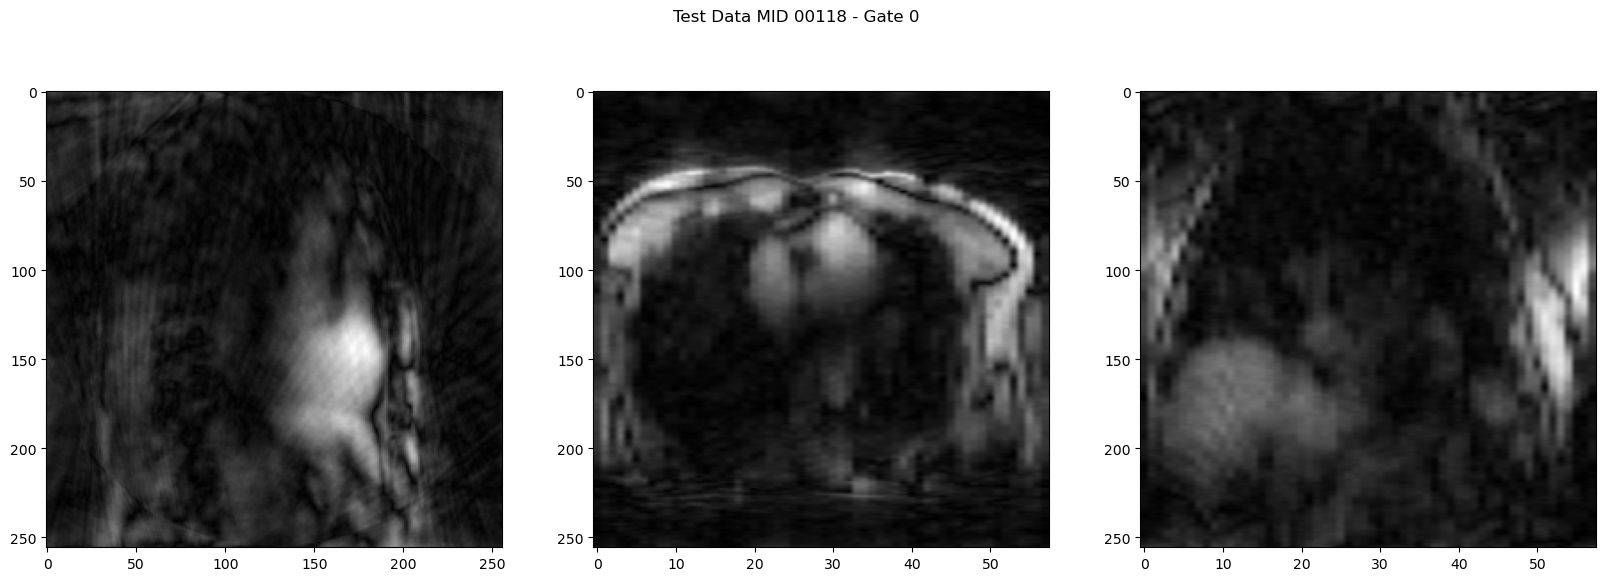

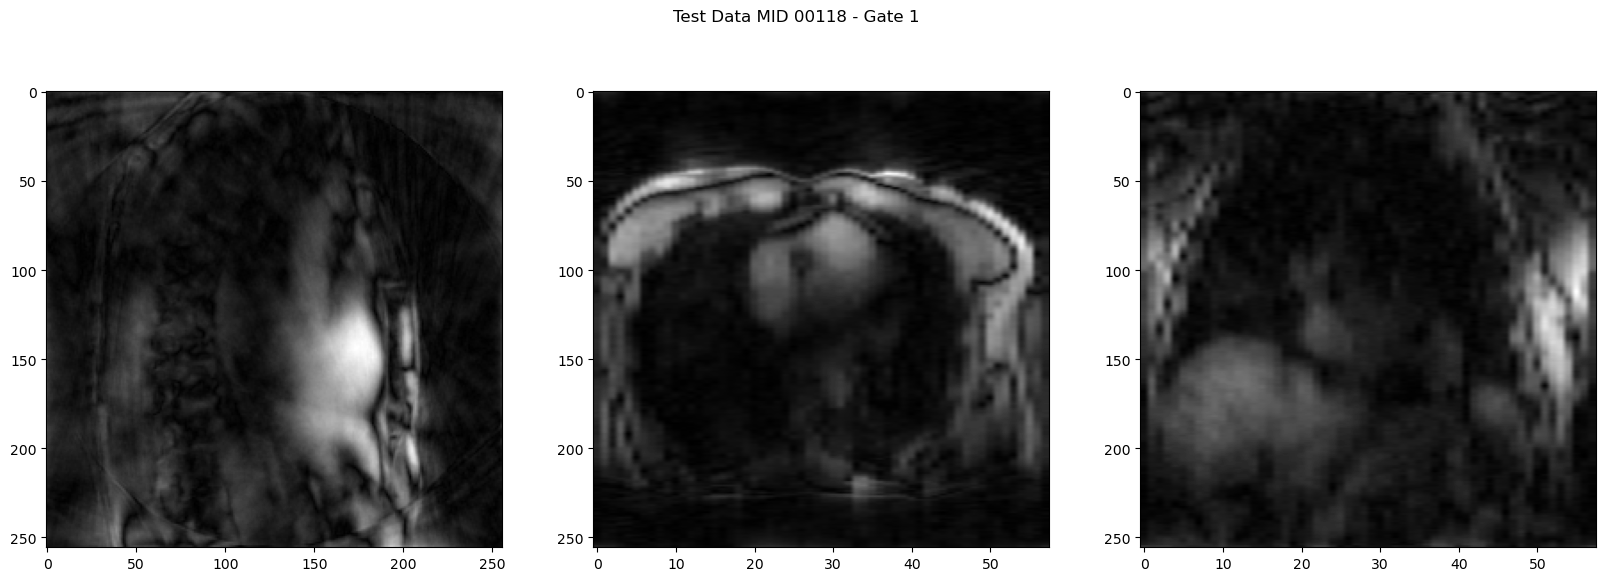

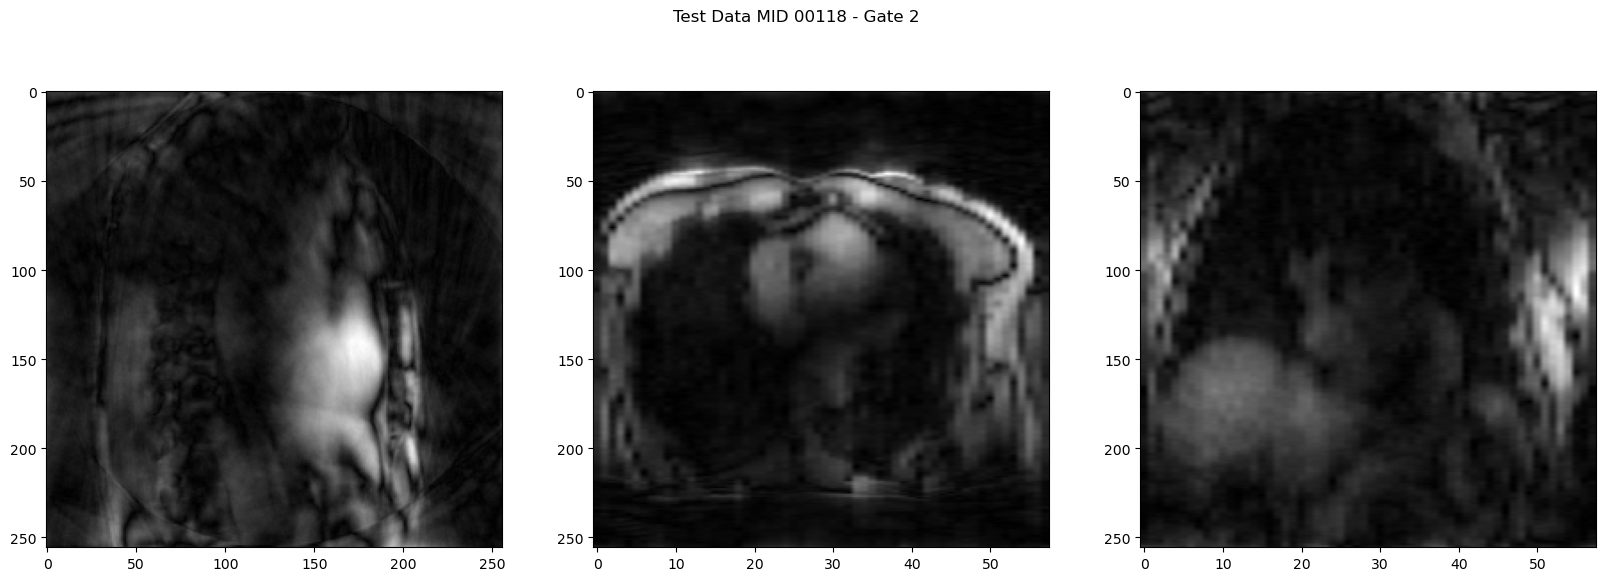

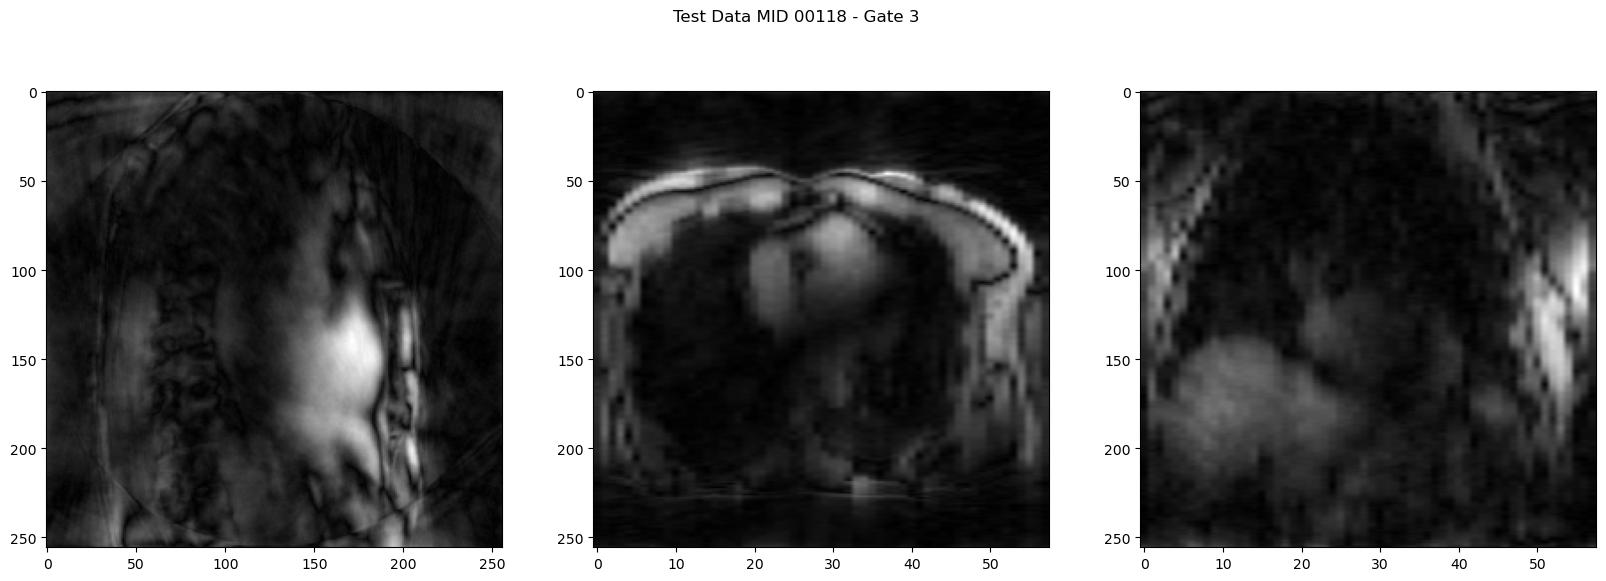

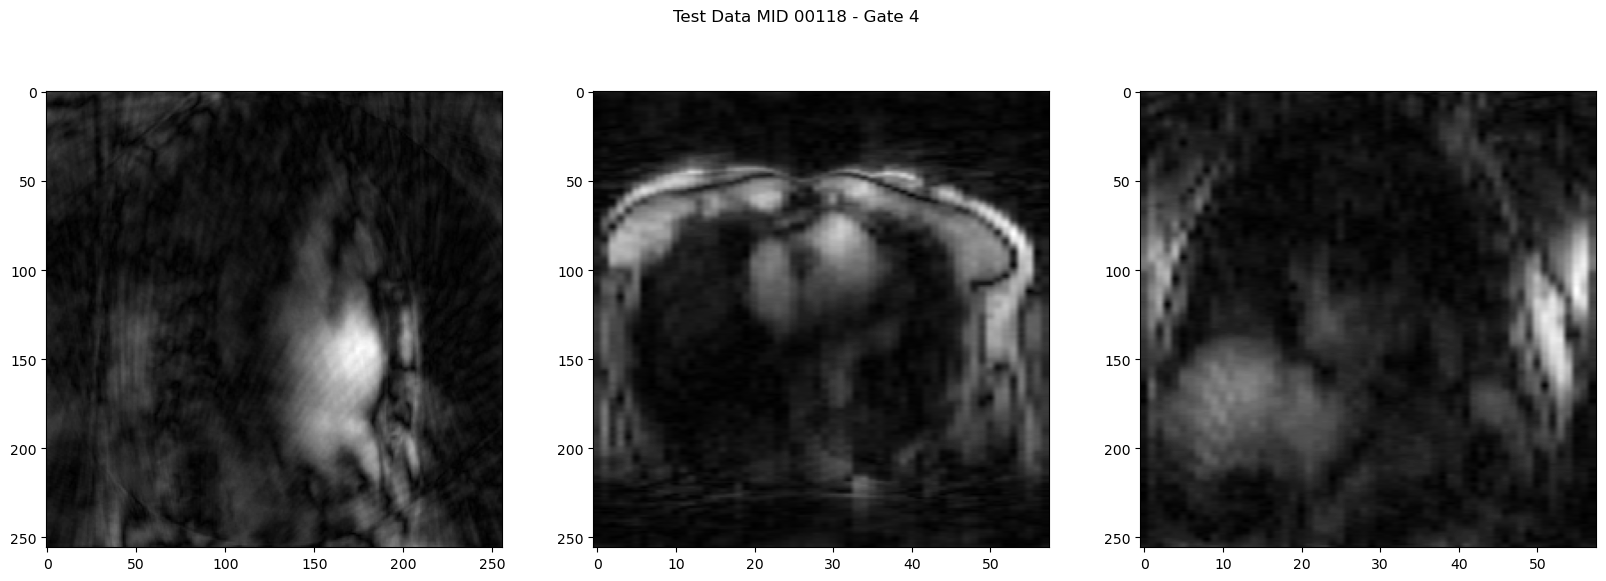

In [44]:
from scipy import ndimage
def rotate_90(img):
    return ndimage.rotate(img,-90)


for gate in range(num_gates):
    output_0 = np.abs(output[...,gate])
    Nz, Ny, Nx = output_0.shape 

    fig, axs = plt.subplots(1,3, figsize=(20,20))
    axs[0].imshow((output_0[Nz//2, :, :]), cmap='gray')
    axs[1].imshow(np.flipud(rotate_90(output_0[:, Ny//2, :])), aspect=Nz/Ny, cmap='gray')
    axs[2].imshow(rotate_90(output_0[:, :, Nx//2]), aspect=Nz/Ny, cmap='gray')
    fig.suptitle(f"Test Data MID 00118 - Gate {gate}", y=0.65)

## After going through all partitions, we have maximum of 40 spokes we can assign 

### Save array

In [45]:
import pickle

with open(output_path / 'starvibe_allcoils_recon.pkl', 'wb') as f:
    pickle.dump(output, f)

with open(output_path / 'Fs.pkl', 'wb') as f:
    pickle.dump(Fs, f)

with open(output_path / 'data_bins.pkl', 'wb') as f:
    pickle.dump(data_bins, f)
